# Boosting Classification

### 1. Setup and Data Loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import os
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'RHMD_Engineered.csv')
df = pd.read_csv(DATA_PATH)

In [5]:
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
print(df.columns.tolist())

Dataset shape: (20355, 40)

Columns in the dataset:
['author', 'score', 'subreddit', 'timestamp', 'title', 'text', 'year_month', 'year', 'month', 'day', 'day_of_week', 'hour', 'title_word_count', 'title_char_count', 'text_word_count', 'text_char_count', 'total_word_count', 'pre_covid', 'pandemic_phase', 'title_sentiment', 'text_sentiment', 'overall_sentiment', 'textblob_sentiment', 'textblob_subjectivity', 'negative_emotion', 'positive_emotion', 'sadness', 'fear', 'death', 'suffering', 'pain', 'shame', 'violence', 'love', 'optimism', 'tokens', 'dominant_topic', 'topic_contribution', 'topic_keywords', 'distress_score']


### 2. Data Preparation and Splitting

In [6]:
mentalhealth_df = df[df['subreddit'] == 'mentalhealth'].copy()
df = df[df['subreddit'] != 'mentalhealth'].copy()

In [7]:
print(f"Number of posts from specific mental health subreddits: {len(df)}")
print(f"Number of general mentalhealth posts to be classified: {len(mentalhealth_df)}")

Number of posts from specific mental health subreddits: 16178
Number of general mentalhealth posts to be classified: 4177


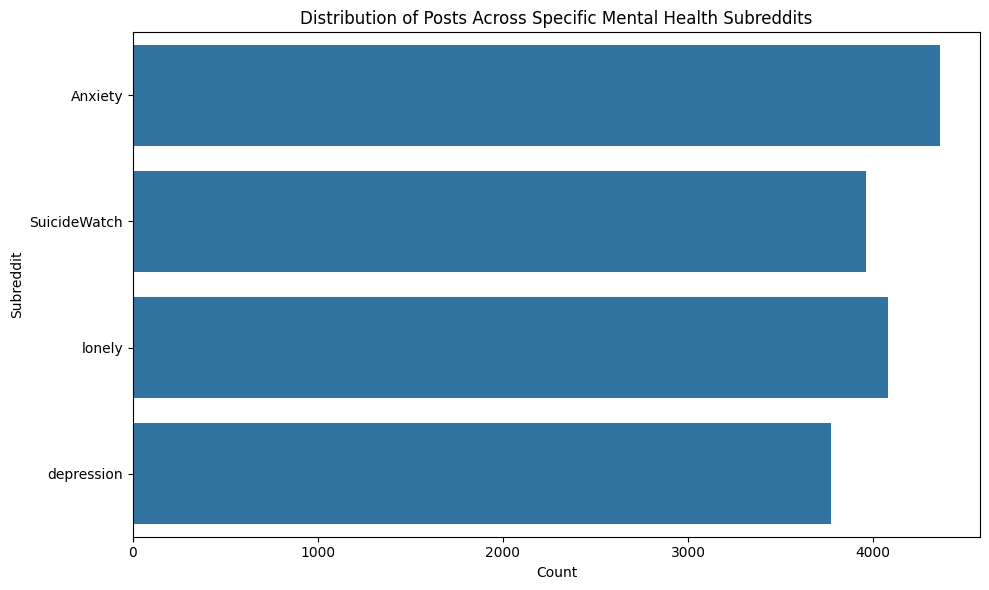

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(y='subreddit', data=df)
plt.title('Distribution of Posts Across Specific Mental Health Subreddits')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.show()

In [10]:
feature_columns = [
    'title_sentiment', 'text_sentiment', 'overall_sentiment', 'textblob_sentiment', 'textblob_subjectivity',
    'negative_emotion', 'positive_emotion', 'sadness', 'fear', 'death', 'suffering', 'pain', 'shame', 'violence', 'love', 'optimism',
    'title_word_count', 'text_word_count',
    'dominant_topic', 'topic_contribution',
    'distress_score'
]

In [11]:
X = df[feature_columns]
y = df['subreddit']

In [12]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
for i, subreddit in enumerate(label_encoder.classes_):
    print(f"{subreddit} -> {i}")

Anxiety -> 0
SuicideWatch -> 1
depression -> 2
lonely -> 3


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [15]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (12942, 21)
Testing set shape: (3236, 21)


In [17]:
X_mentalhealth = mentalhealth_df[feature_columns]
print(f"Mentalhealth posts feature set shape: {X_mentalhealth.shape}")

Mentalhealth posts feature set shape: (4177, 21)


### 3. Baseline Models

### 3.1 Gradient Boosting Classifier

In [18]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

In [19]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

In [20]:
gb_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

In [21]:
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")

Gradient Boosting Accuracy: 0.5698


In [22]:
print("\nClassification Report:")
print(classification_report(y_test, gb_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.73      0.75      0.74       872
SuicideWatch       0.52      0.56      0.54       792
  depression       0.42      0.34      0.38       755
      lonely       0.56      0.60      0.58       817

    accuracy                           0.57      3236
   macro avg       0.56      0.56      0.56      3236
weighted avg       0.56      0.57      0.57      3236



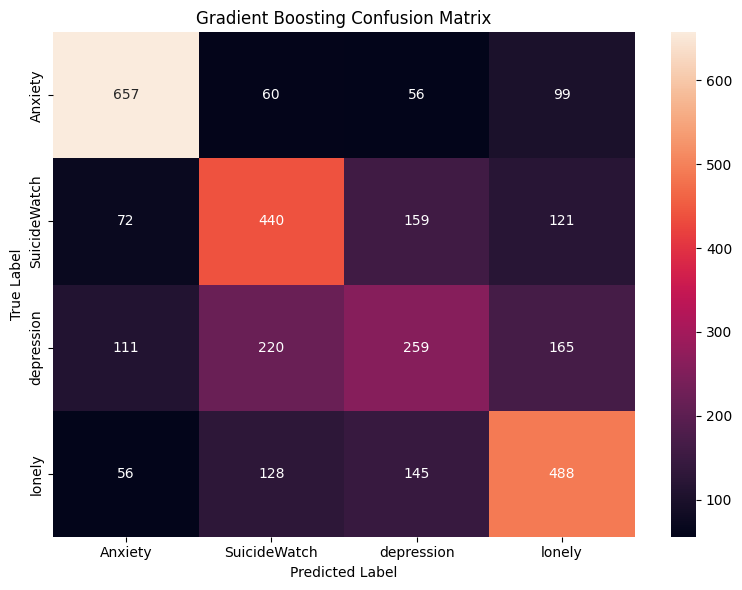

In [23]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, gb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Gradient Boosting Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 3.2 XGBoost Classifier

In [24]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

In [25]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

In [27]:
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.5800


In [28]:
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.74      0.76      0.75       872
SuicideWatch       0.53      0.58      0.55       792
  depression       0.45      0.34      0.39       755
      lonely       0.56      0.62      0.58       817

    accuracy                           0.58      3236
   macro avg       0.57      0.57      0.57      3236
weighted avg       0.57      0.58      0.57      3236



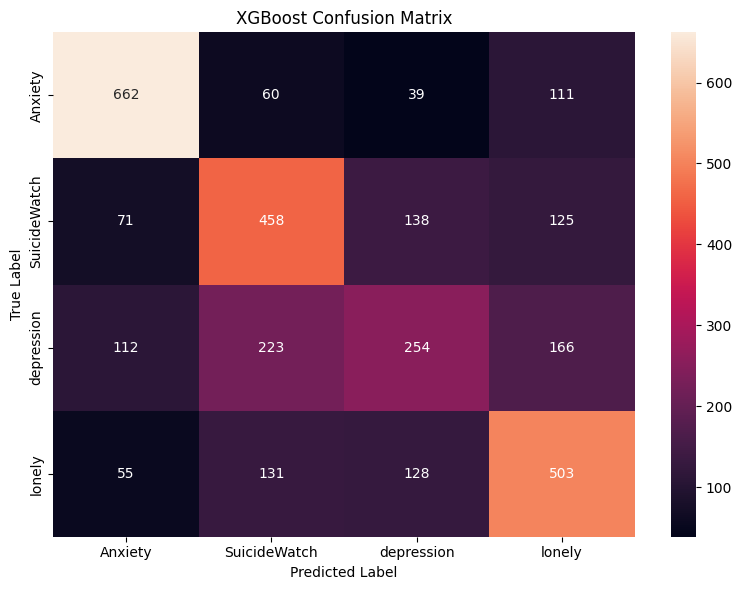

In [30]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('XGBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 3.3 LGBM Classifier

In [37]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42,
    verbose=-1
)

In [38]:
lgb_model.fit(X_train, y_train)

LGBMClassifier(max_depth=5, n_estimators=200, random_state=42, subsample=0.8,
               verbose=-1)

In [39]:
lgb_pred = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_pred)

In [40]:
print(f"LightGBM Accuracy: {lgb_accuracy:.4f}")

LightGBM Accuracy: 0.5766


In [41]:
print("\nClassification Report:")
print(classification_report(y_test, lgb_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.73      0.76      0.74       872
SuicideWatch       0.52      0.56      0.54       792
  depression       0.46      0.35      0.40       755
      lonely       0.55      0.61      0.58       817

    accuracy                           0.58      3236
   macro avg       0.56      0.57      0.56      3236
weighted avg       0.57      0.58      0.57      3236



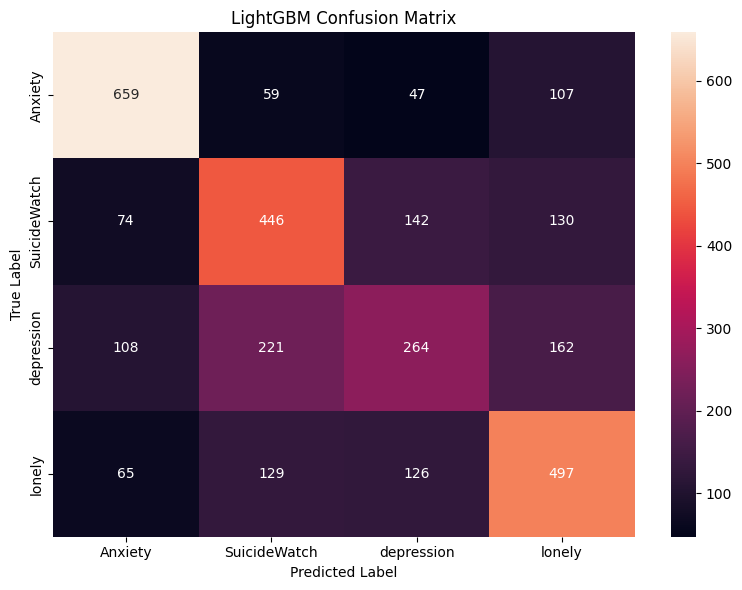

In [42]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, lgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('LightGBM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 3.4 CatBoost Classifier

In [43]:
cat_model = cb.CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=5,
    random_seed=42,
    verbose=0
)

In [44]:
cat_model.fit(X_train, y_train)

In [45]:
cat_pred = cat_model.predict(X_test)
cat_accuracy = accuracy_score(y_test, cat_pred)

In [46]:
print(f"CatBoost Accuracy: {cat_accuracy:.4f}")

CatBoost Accuracy: 0.5754


In [47]:
print("\nClassification Report:")
print(classification_report(y_test, cat_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.74      0.75      0.74       872
SuicideWatch       0.52      0.56      0.54       792
  depression       0.44      0.31      0.36       755
      lonely       0.55      0.65      0.60       817

    accuracy                           0.58      3236
   macro avg       0.56      0.57      0.56      3236
weighted avg       0.57      0.58      0.57      3236



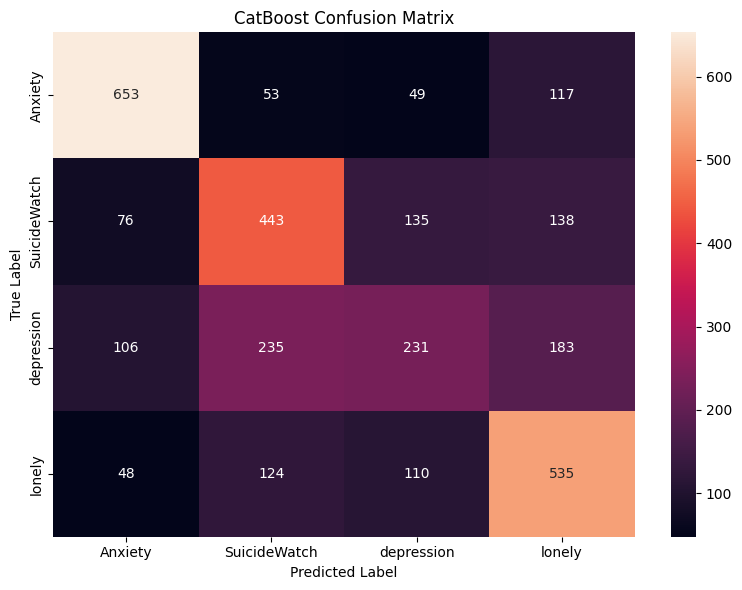

In [48]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, cat_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('CatBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 4. Hyperparameter Optimization

### 4.1 Gradient Boosting Classifier

In [49]:
param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'subsample': Real(0.6, 1.0, prior='uniform')
}

In [50]:
base_model = GradientBoostingClassifier(random_state=42)

In [51]:
bayes_search = BayesSearchCV(
    estimator=base_model,
    search_spaces=param_space,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=3
)

In [52]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END learning_rate=0.03416312199509112, max_depth=8, min_samples_leaf=9, min_samples_split=8, n_estimators=352, subsample=0.7656474529942154;, score=0.566 total time= 3.3min
[CV 3/5] END learning_rate=0.03416312199509112, max_depth=8, min_samples_leaf=9, min_samples_split=8, n_estimators=352, subsample=0.7656474529942154;, score=0.565 total time= 3.4min
[CV 5/5] END learning_rate=0.03416312199509112, max_depth=8, min_samples_leaf=9, min_samples_split=8, n_estimators=352, subsample=0.7656474529942154;, score=0.580 total time= 3.4min
[CV 1/5] END learning_rate=0.03416312199509112, max_depth=8, min_samples_leaf=9, min_samples_split=8, n_estimators=352, subsample=0.7656474529942154;, score=0.560 total time= 3.4min
[CV 2/5] END learning_rate=0.03416312199509112, max_depth=8, min_samples_leaf=9, min_samples_split=8, n_estimators=352, subsample=0.7656474529942154;, score=0.565 total time= 3.4min
Fitting 5 folds for each of 1 c

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=GradientBoostingClassifier(random_state=42), n_iter=20,
              n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'learning_rate': Real(low=0.01, high=0.2, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')},
              verbose=3)

In [53]:
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best cross-validation accuracy: {bayes_search.best_score_:.4f}")

Best parameters: OrderedDict({'learning_rate': 0.055084050893176494, 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.9438828650313843})
Best cross-validation accuracy: 0.5732


In [54]:
best_gb = bayes_search.best_estimator_

In [55]:
y_pred_best = best_gb.predict(X_test)

In [56]:
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best gb accuracy on test set: {accuracy_best:.4f}")

Best gb accuracy on test set: 0.5791


In [57]:
print("\nClassification Report for Best GB Model:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))


Classification Report for Best GB Model:
              precision    recall  f1-score   support

     Anxiety       0.74      0.75      0.75       872
SuicideWatch       0.53      0.57      0.55       792
  depression       0.45      0.35      0.39       755
      lonely       0.56      0.61      0.58       817

    accuracy                           0.58      3236
   macro avg       0.57      0.57      0.57      3236
weighted avg       0.57      0.58      0.57      3236



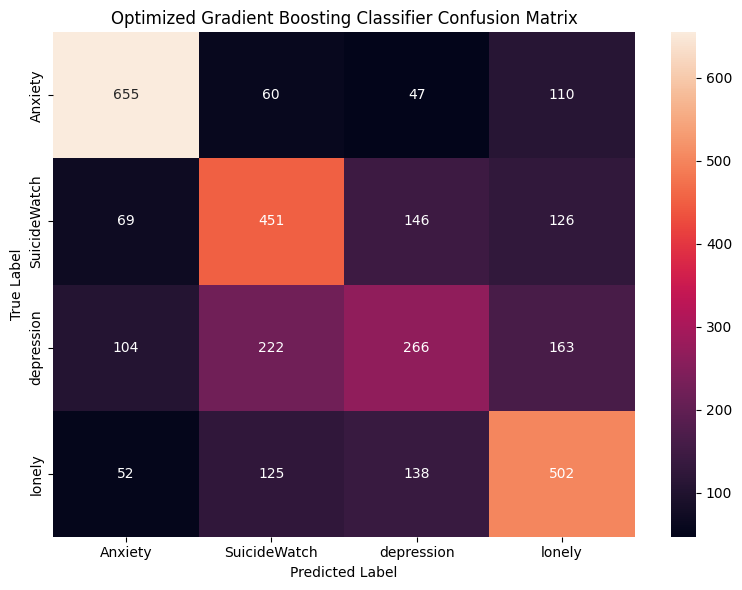

In [58]:
plt.figure(figsize=(8, 6))
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Optimized Gradient Boosting Classifier Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 4.2 XGBoost Classifier

In [60]:
param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.6, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
    'gamma': Real(0.1, 5, prior='log-uniform'),
    'min_child_weight': Integer(1, 10)
}

In [64]:
base_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, verbosity = 0)

In [65]:
bayes_search = BayesSearchCV(
    estimator=base_model,
    search_spaces=param_space,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=3
)

In [66]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 1/5] END colsample_bytree=0.7640415835413256, gamma=1.7233925413725917, learning_rate=0.16356457461011642, max_depth=5, min_child_weight=7, n_estimators=236, subsample=0.7403725339596576;, score=0.564 total time=   3.2s
[CV 5/5] END colsample_bytree=0.7640415835413256, gamma=1.7233925413725917, learning_rate=0.16356457461011642, max_depth=5, min_child_weight=7, n_estimators=236, subsample=0.7403725339596576;, score=0.582 total time=   3.1s
[CV 3/5] END colsample_bytree=0.7640415835413256, gamma=1.7233925413725917, learning_rate=0.16356457461011642, max_depth=5, min_child_weight=7, n_estimators=236, subsample=0.7403725339596576;, score=0.566 total time=   3.1s
[CV 2/5] END colsample_bytree=0.7640415835413256, gamma=1.7233925413725917, learning_rate=0.16356457461011642, max_depth=5, min_child_weight=7, n_estimators=236, subsample=0.7403725339596576;, score=0.573 total time=   3.2s
[CV 4/5] END colsample_bytree=0.7640415835413256, gamma=1.7233925413725917, learning_rate=0.163564574610

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='mlogloss',
                                      feature_types=None, feature_weights=None,
                                      gamma=None,...
                             'learning_rate': Real(low=0.01, high=0.2, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')},
              verbose=3)

In [67]:
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best cross-validation accuracy: {bayes_search.best_score_:.4f}")

Best parameters: OrderedDict({'colsample_bytree': 0.7640415835413256, 'gamma': 1.7233925413725917, 'learning_rate': 0.16356457461011642, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 236, 'subsample': 0.7403725339596576})
Best cross-validation accuracy: 0.5723


In [68]:
best_xgb = bayes_search.best_estimator_

In [69]:
y_pred_best = best_xgb.predict(X_test)

In [70]:
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best xgb accuracy on test set: {accuracy_best:.4f}")

Best xgb accuracy on test set: 0.5797


In [71]:
print("\nClassification Report for Best XGB Model:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))


Classification Report for Best XGB Model:
              precision    recall  f1-score   support

     Anxiety       0.74      0.75      0.75       872
SuicideWatch       0.53      0.58      0.55       792
  depression       0.45      0.34      0.38       755
      lonely       0.55      0.62      0.58       817

    accuracy                           0.58      3236
   macro avg       0.57      0.57      0.57      3236
weighted avg       0.57      0.58      0.57      3236



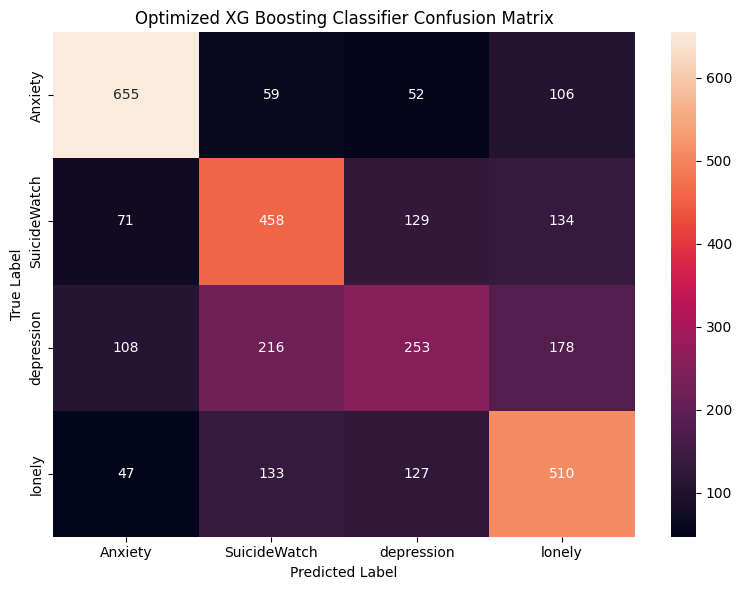

In [72]:
plt.figure(figsize=(8, 6))
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Optimized XG Boosting Classifier Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 4.3 LGBM Classifier

In [75]:
param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.6, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
    'reg_alpha': Real(0.1, 10, prior='log-uniform'),
    'reg_lambda': Real(0.1, 10, prior='log-uniform'),
    'num_leaves': Integer(20, 100),
    'min_child_samples': Integer(1, 50)
}

In [76]:
base_model = lgb.LGBMClassifier(random_state=42)

In [77]:
bayes_search = BayesSearchCV(
    estimator=base_model,
    search_spaces=param_space,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=3
)

In [78]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028954 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4852
[LightGBM] [Info] Total Bins 4847

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=LGBMClassifier(random_state=42), n_iter=20, n_jobs=-1,
              random_state=42, scoring='accuracy',
              search_spaces={'colsample_bytree': Real(low=0.6, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=0.2, prior='log-uniform', transform='normalize')...
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=20, high=100, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.1, high=10, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.1, high=10, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')},
              verbose=3)

In [79]:
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best cross-validation accuracy: {bayes_search.best_score_:.4f}")

Best parameters: OrderedDict({'colsample_bytree': 0.6357548178969294, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_samples': 13, 'n_estimators': 500, 'num_leaves': 68, 'reg_alpha': 10.0, 'reg_lambda': 5.662012932766724, 'subsample': 1.0})
Best cross-validation accuracy: 0.5727


In [80]:
best_lgbm = bayes_search.best_estimator_

In [81]:
y_pred_best = best_lgbm.predict(X_test)

In [82]:
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best lgbm accuracy on test set: {accuracy_best:.4f}")

Best lgbm accuracy on test set: 0.5844


In [83]:
print("\nClassification Report for Best LGBM Model:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))


Classification Report for Best LGBM Model:
              precision    recall  f1-score   support

     Anxiety       0.74      0.75      0.75       872
SuicideWatch       0.54      0.59      0.56       792
  depression       0.45      0.32      0.38       755
      lonely       0.55      0.65      0.60       817

    accuracy                           0.58      3236
   macro avg       0.57      0.58      0.57      3236
weighted avg       0.58      0.58      0.58      3236



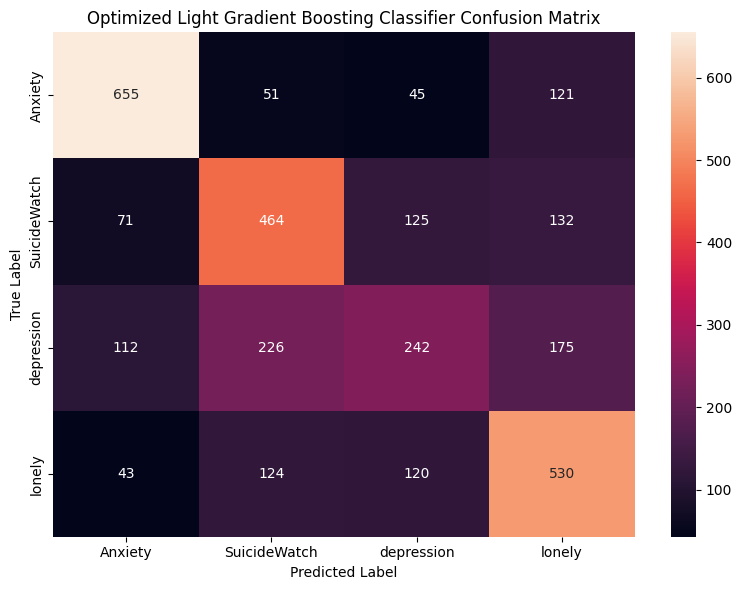

In [84]:
plt.figure(figsize=(8, 6))
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Optimized Light Gradient Boosting Classifier Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 4.4 CatBoost Classifier

In [85]:
param_space = {
    'iterations': Integer(50, 500),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'depth': Integer(3, 10),
    'l2_leaf_reg': Real(1, 10, prior='uniform'),
    'border_count': Integer(32, 255),
    'bagging_temperature': Real(0, 1, prior='uniform')
}

In [86]:
cat_model = cb.CatBoostClassifier(random_seed=42, verbose=0)

In [89]:
bayes_search = BayesSearchCV(
    estimator=cat_model,
    search_spaces=param_space,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=3
)

In [90]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 5/5] END bagging_temperature=0.41010395885331385, border_count=194, depth=10, iterations=192, l2_leaf_reg=7.031331534420412, learning_rate=0.034576478730387106;, score=0.570 total time= 1.5min
[CV 1/5] END bagging_temperature=0.41010395885331385, border_count=194, depth=10, iterations=192, l2_leaf_reg=7.031331534420412, learning_rate=0.034576478730387106;, score=0.556 total time= 1.5min
[CV 3/5] END bagging_temperature=0.41010395885331385, border_count=194, depth=10, iterations=192, l2_leaf_reg=7.031331534420412, learning_rate=0.034576478730387106;, score=0.555 total time= 1.5min
[CV 4/5] END bagging_temperature=0.41010395885331385, border_count=194, depth=10, iterations=192, l2_leaf_reg=7.031331534420412, learning_rate=0.034576478730387106;, score=0.556 total time= 1.5min
[CV 2/5] END bagging_temperature=0.41010395885331385, border_count=194, depth=10, iterations=192, l2_leaf_reg=7.031331534420412, learning_rate=0.034576478730387106;, score=0.562 total time= 1.5min
Fitting 5 folds

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=<catboost.core.CatBoostClassifier object at 0x7f64085504d0>,
              n_iter=20, n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'bagging_temperature': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'border_count': Integer(low=32, high=255, prior='uniform', transform='normalize'),
                             'depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'iterations': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'l2_leaf_reg': Real(low=1, high=10, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=0.2, prior='log-uniform', transform='normalize')},
              verbose=3)

In [91]:
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best cross-validation accuracy: {bayes_search.best_score_:.4f}")

Best parameters: OrderedDict({'bagging_temperature': 0.0, 'border_count': 189, 'depth': 3, 'iterations': 271, 'l2_leaf_reg': 10.0, 'learning_rate': 0.2})
Best cross-validation accuracy: 0.5748


In [92]:
best_cb = bayes_search.best_estimator_

In [93]:
y_pred_best = best_cb.predict(X_test)

In [94]:
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best catboost accuracy on test set: {accuracy_best:.4f}")

Best catboost accuracy on test set: 0.5763


In [95]:
print("\nClassification Report for Best CatBoost Model:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))


Classification Report for Best CatBoost Model:
              precision    recall  f1-score   support

     Anxiety       0.74      0.75      0.74       872
SuicideWatch       0.52      0.57      0.54       792
  depression       0.46      0.32      0.38       755
      lonely       0.55      0.64      0.59       817

    accuracy                           0.58      3236
   macro avg       0.56      0.57      0.56      3236
weighted avg       0.57      0.58      0.57      3236



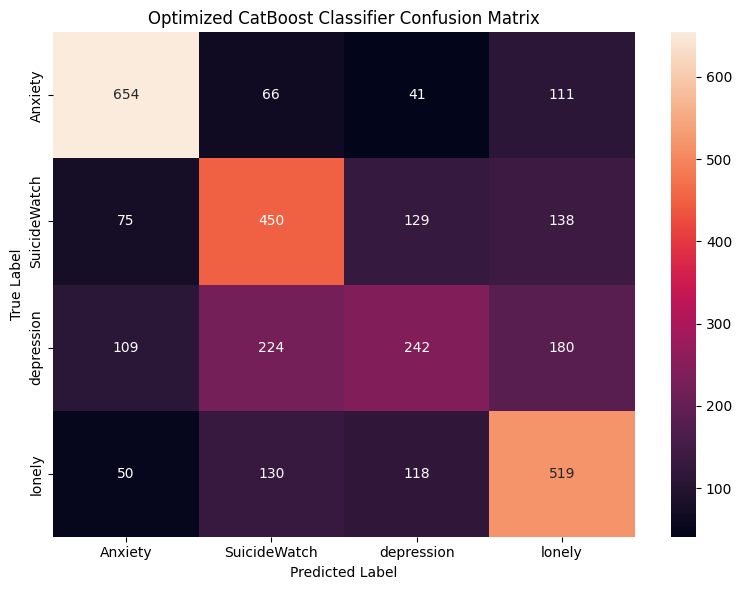

In [96]:
plt.figure(figsize=(8, 6))
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Optimized CatBoost Classifier Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 5. Stacking Ensemble

In [97]:
base_models = [
    ('gb', best_gb),
    ('xgb', best_xgb),
    ('lgb', best_lgbm),
    ('cat', best_cb)
]

In [100]:
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=best_gb,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

In [101]:
stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4851
[LightGBM] [Info] Number of data points in the train set: 12942, number of used features: 21
[LightGBM] [Info] Start training from score -1.311149
[LightGBM] [Info] Start training from score -1.407062
[LightGBM] [Info] Start training from score -1.455552
[LightGBM] [Info] Start training from score -1.376912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

StackingClassifier(cv=5,
                   estimators=[('gb',
                                GradientBoostingClassifier(learning_rate=0.055084050893176494,
                                                           min_samples_leaf=10,
                                                           n_estimators=500,
                                                           random_state=42,
                                                           subsample=0.9438828650313843)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7640415835413256,
                                              device=None,
                                              earl...
                                               n_estimators=500, num_leaves=68,
                                               random_state=42, reg_alpha=10.0,
                                               reg_lambda=5.662012932766724)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7f641dde0d40>)],
                   final_estimator=GradientBoostingClassifier(learning_rate=0.055084050893176494,
                                                              min_samples_leaf=10,
                                                              n_estimators=500,
                                                              random_state=42,
                                                              subsample=0.9438828650313843),
                   n_jobs=-1, stack_method='predict_proba')

In [102]:
stacking_pred = stacking_model.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_pred)

In [103]:
print(f"Stacking Ensemble Accuracy: {stacking_accuracy:.4f}")

Stacking Ensemble Accuracy: 0.5711


In [104]:
print("\nClassification Report:")
print(classification_report(y_test, stacking_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.73      0.74      0.74       872
SuicideWatch       0.51      0.59      0.55       792
  depression       0.44      0.30      0.35       755
      lonely       0.54      0.62      0.58       817

    accuracy                           0.57      3236
   macro avg       0.56      0.56      0.56      3236
weighted avg       0.56      0.57      0.56      3236



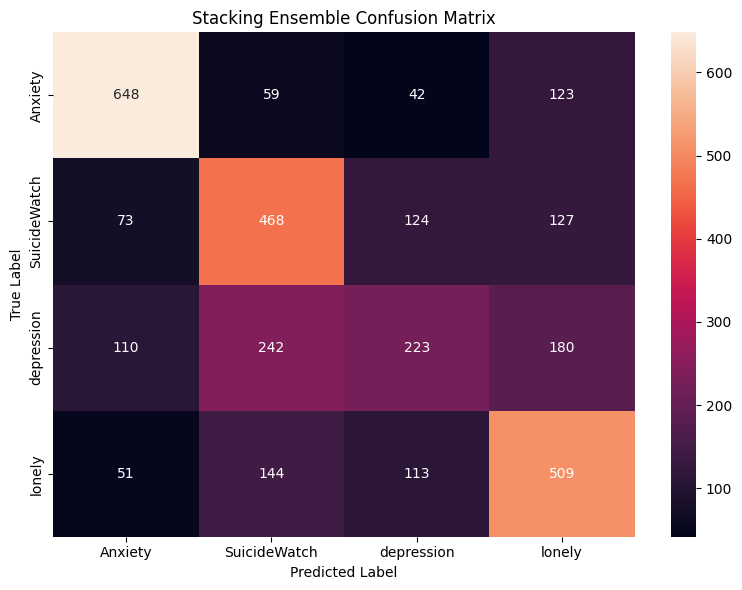

In [106]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, stacking_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Stacking Ensemble Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [107]:
model_results = pd.DataFrame({
    'Model': ['Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost', 'Stacking Ensemble'],
    'Accuracy': [0.5791, 0.5797, 0.5844, 0.5763, stacking_accuracy]
})

In [108]:
model_results = model_results.sort_values('Accuracy', ascending=False)

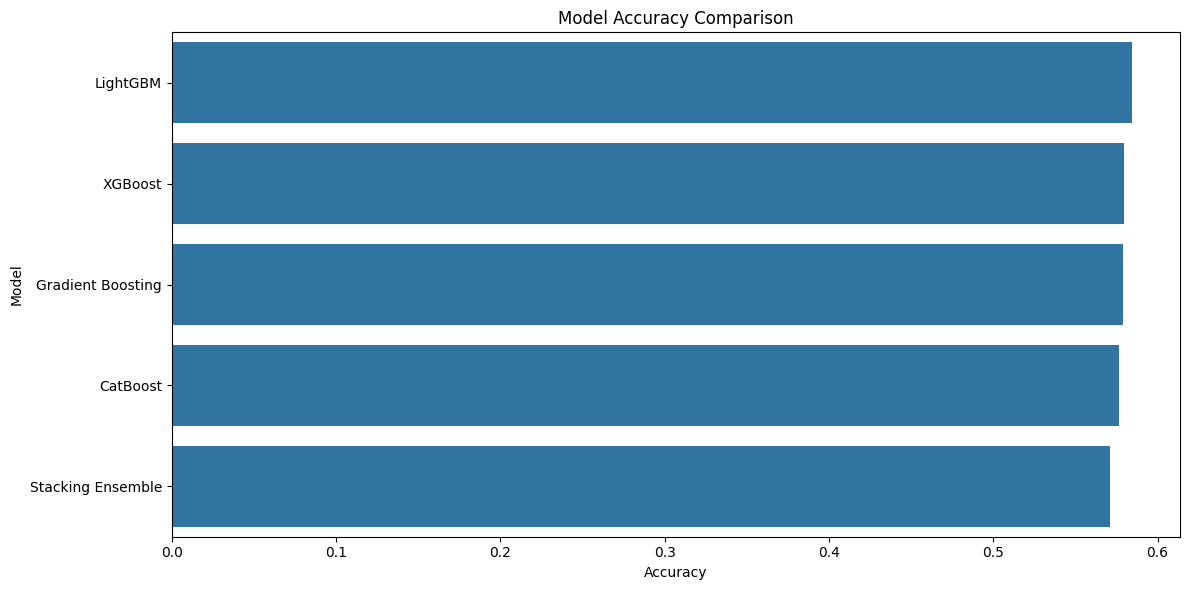

In [111]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=model_results)
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.tight_layout()
plt.show()

### 6. Feature Importance

In [112]:
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        try:
            importances = model.get_feature_importance()
        except:
            print(f"Cannot extract feature importance from {model_name}")
            return
    
    sorted_idx = np.argsort(importances)

    plt.figure(figsize=(10, 8))
    plt.barh(range(min(15, len(sorted_idx))), importances[sorted_idx[-15:]], align='center')
    plt.yticks(range(min(15, len(sorted_idx))), np.array(feature_names)[sorted_idx[-15:]])
    plt.title(f'Top 15 Important Features for {model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

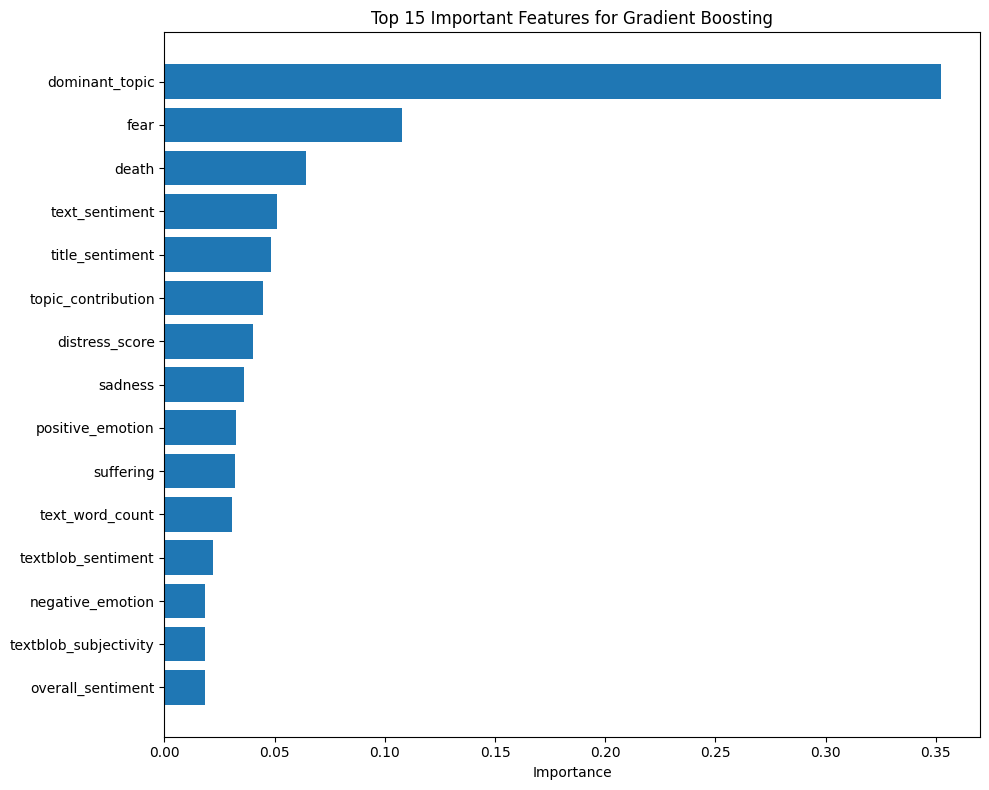

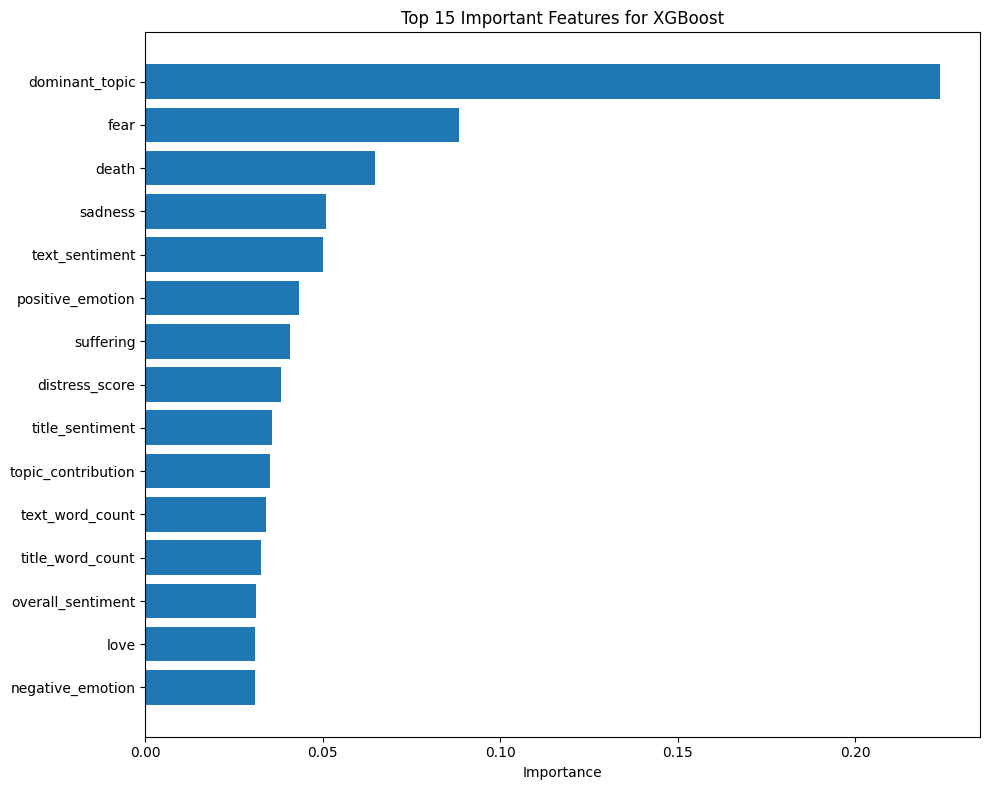

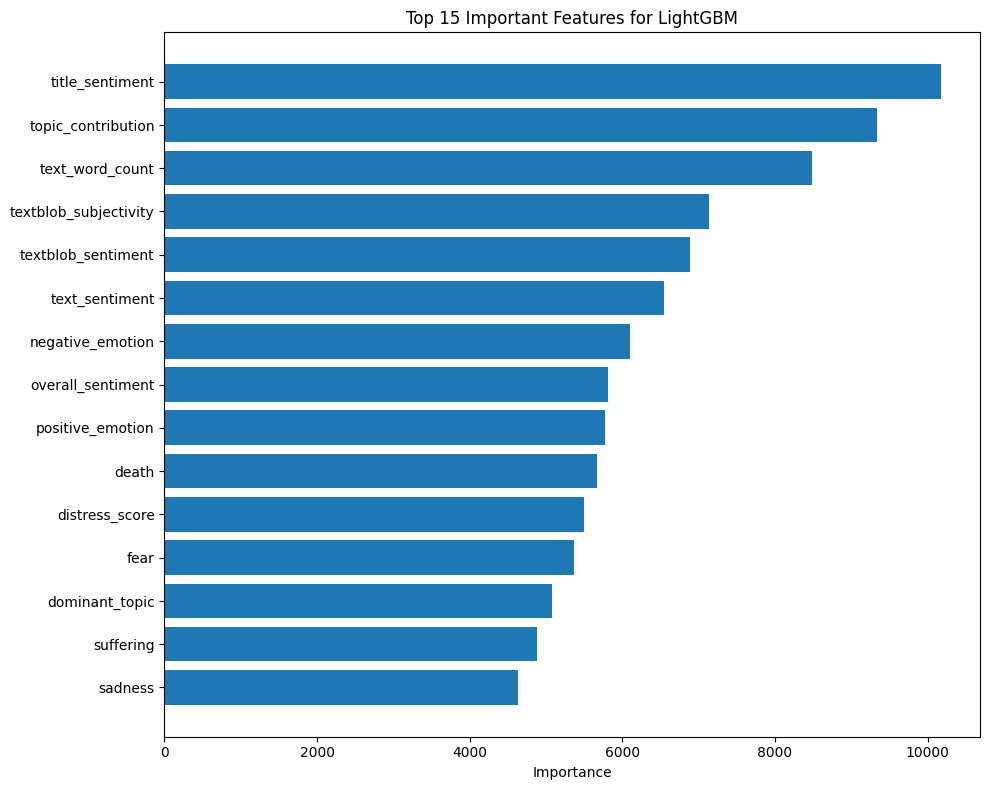

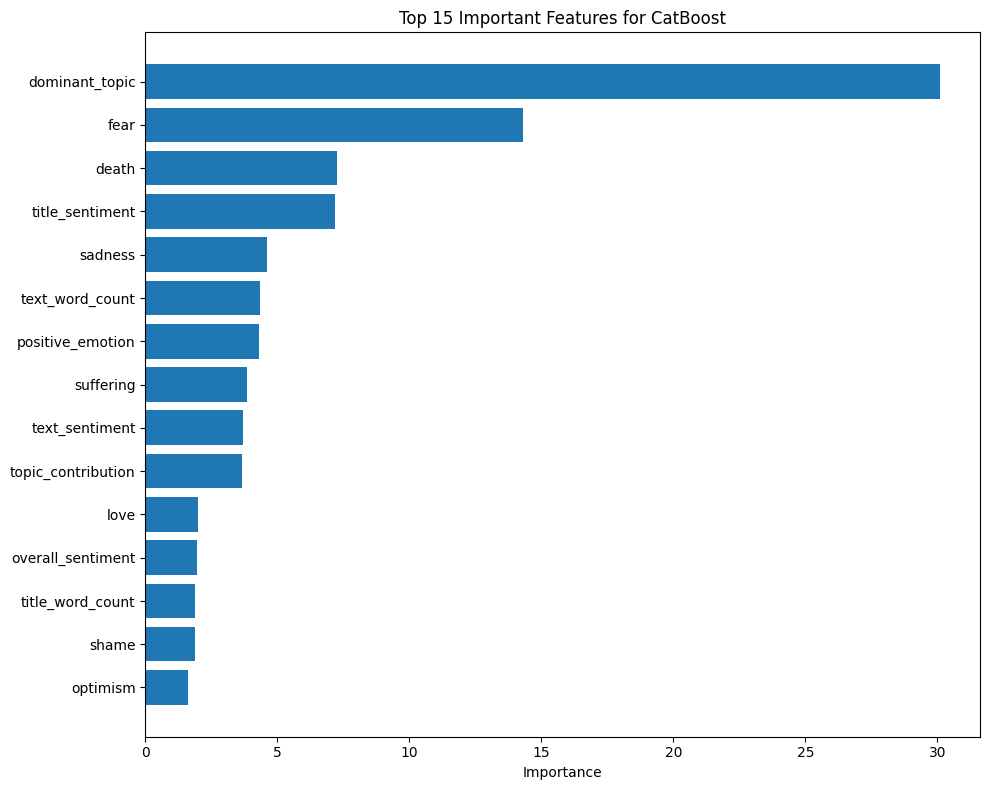

In [113]:
plot_feature_importance(best_gb, 'Gradient Boosting', feature_columns)
plot_feature_importance(best_xgb, 'XGBoost', feature_columns)
plot_feature_importance(best_lgbm, 'LightGBM', feature_columns)
plot_feature_importance(best_cb, 'CatBoost', feature_columns)

In [122]:
def get_top_features(model, feature_names, n=5):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        try:
            importances = model.get_feature_importance()
        except:
            return []
    
    indices = np.argsort(importances)[-n:]
    return [feature_names[i] for i in reversed(indices)]

In [123]:
gb_top = get_top_features(best_gb, feature_columns)
xgb_top = get_top_features(best_xgb, feature_columns)
lgb_top = get_top_features(best_lgbm, feature_columns)
cat_top = get_top_features(best_cb, feature_columns)

In [124]:
top_features_df = pd.DataFrame({
    'Gradient Boosting': gb_top,
    'XGBoost': xgb_top,
    'LightGBM': lgb_top,
    'CatBoost': cat_top
})

In [125]:
print("Top 5 features for each model:")
print(top_features_df)

Top 5 features for each model:
  Gradient Boosting         XGBoost               LightGBM         CatBoost
0    dominant_topic  dominant_topic        title_sentiment   dominant_topic
1              fear            fear     topic_contribution             fear
2             death           death        text_word_count            death
3    text_sentiment         sadness  textblob_subjectivity  title_sentiment
4   title_sentiment  text_sentiment     textblob_sentiment          sadness


### 7. Classifying Mentalhealth Posts

In [126]:
final_model = stacking_model if stacking_accuracy > accuracy_best else best_lgbm
final_model_name = "Stacking Ensemble" if stacking_accuracy > accuracy_best else f"Optimized Light GBM"
print(f"\nUsing {final_model_name} to classify mentalhealth posts")


Using Optimized Light GBM to classify mentalhealth posts


In [127]:
mentalhealth_predictions = final_model.predict(X_mentalhealth)
mentalhealth_pred_proba = final_model.predict_proba(X_mentalhealth)

In [128]:
mentalhealth_pred_labels = label_encoder.inverse_transform(mentalhealth_predictions)
mentalhealth_df['predicted_subreddit'] = mentalhealth_pred_labels

In [129]:
for i, class_name in enumerate(label_encoder.classes_):
    mentalhealth_df[f'prob_{class_name}'] = mentalhealth_pred_proba[:, i]

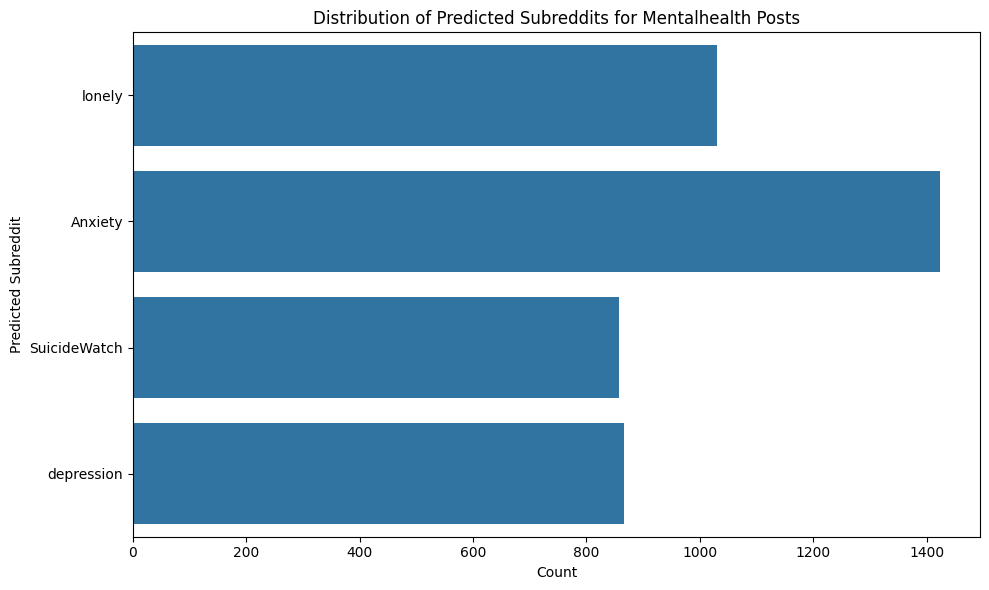

In [130]:
plt.figure(figsize=(10, 6))
sns.countplot(y='predicted_subreddit', data=mentalhealth_df)
plt.title('Distribution of Predicted Subreddits for Mentalhealth Posts')
plt.xlabel('Count')
plt.ylabel('Predicted Subreddit')
plt.tight_layout()
plt.show()

In [131]:
predicted_counts = mentalhealth_df['predicted_subreddit'].value_counts()
predicted_percentages = predicted_counts / predicted_counts.sum() * 100

In [132]:
print("\nDistribution of mentalhealth posts into specific subreddits:")
for subreddit, percentage in predicted_percentages.items():
    print(f"{subreddit}: {percentage:.2f}%")


Distribution of mentalhealth posts into specific subreddits:
Anxiety: 34.07%
lonely: 24.66%
depression: 20.73%
SuicideWatch: 20.54%


In [133]:
confidence_levels = mentalhealth_df[[f'prob_{class_name}' for class_name in label_encoder.classes_]].max(axis=1)

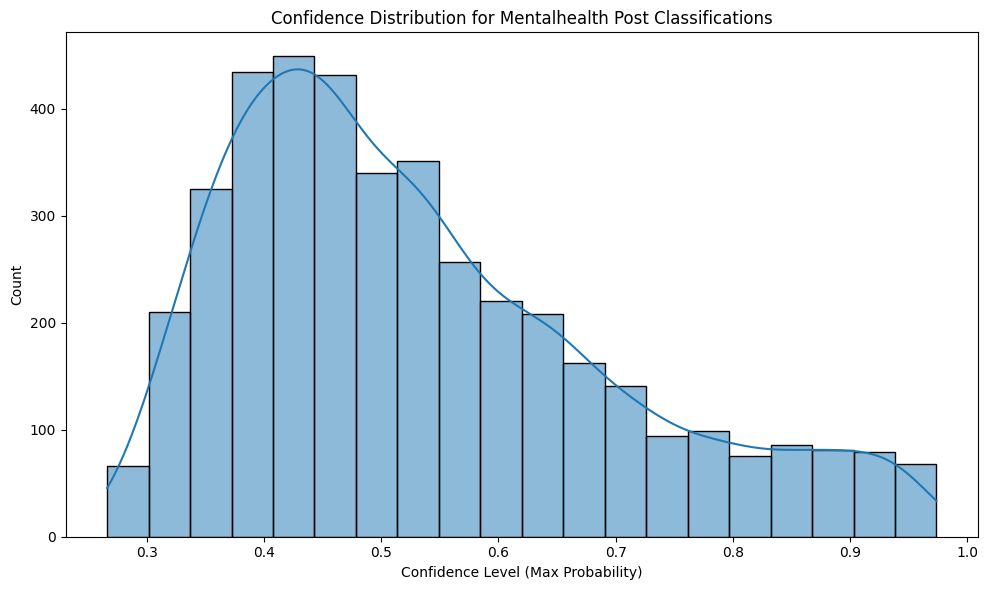

In [134]:
plt.figure(figsize=(10, 6))
sns.histplot(confidence_levels, bins=20, kde=True)
plt.title('Confidence Distribution for Mentalhealth Post Classifications')
plt.xlabel('Confidence Level (Max Probability)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [135]:
high_confidence = mentalhealth_df[confidence_levels >= 0.8]
low_confidence = mentalhealth_df[confidence_levels < 0.5]

print(f"\nHigh confidence predictions (>=80%): {len(high_confidence)} posts ({len(high_confidence)/len(mentalhealth_df)*100:.2f}%)")
print(f"Low confidence predictions (<50%): {len(low_confidence)} posts ({len(low_confidence)/len(mentalhealth_df)*100:.2f}%)")


High confidence predictions (>=80%): 379 posts (9.07%)
Low confidence predictions (<50%): 2130 posts (50.99%)


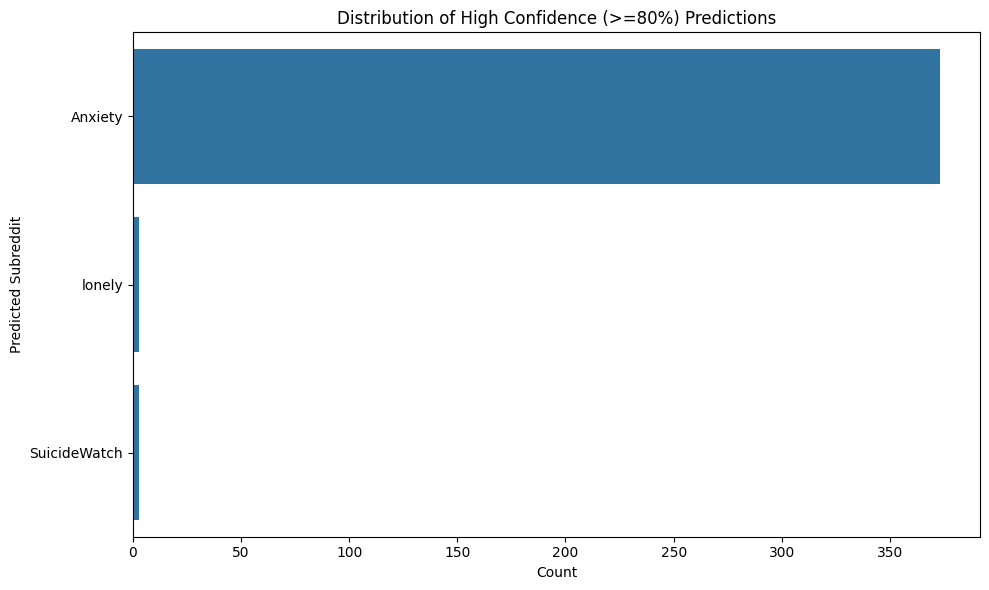

In [136]:
if len(high_confidence) > 0:
    plt.figure(figsize=(10, 6))
    sns.countplot(y='predicted_subreddit', data=high_confidence)
    plt.title('Distribution of High Confidence (>=80%) Predictions')
    plt.xlabel('Count')
    plt.ylabel('Predicted Subreddit')
    plt.tight_layout()
    plt.show()

In [141]:
SAVE_PATH = os.path.join(os.path.dirname(os.getcwd()), 'classifications', 'boosting_classification.csv')
mentalhealth_df.to_csv(SAVE_PATH, index=False)